# Dane techniczne sprzętu

Obliczenia zostały wykonane na komputerze o następujących parametrach:

- Procesor: AMD Ryzen $7$ $4700$U ($8$ rdzeni, $8$ wątków),

- Pamięć RAM: $16$ GB $3200$ MHz

# Biblioteki

In [1]:
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

# Pomocnicze funkcje

## Dokładność przybliżenia funkcji interpolowanej przez wielomian interpolujący 

Przyjmijmy następujące oznaczenia:

$f(x)$ - interpolowana funkcja (funkcja wzorcowa)

$W(x)$ - wielomian interpolujący (przybliżający funkcję wzorcową)

#### Norma z różnicy

$||f(x)-W(x)||$

In [2]:
def abs_diff(f, W, xs):
    return [abs(f(x) - W(x)) for x in xs]

#### Największa różnica

$max_k\{||f(x_k)-W(x_k)||\}$

In [3]:
def max_diff(f, W, xs):
    return max(abs_diff(f, W, xs))

#### Suma kwadratów różnic

$\sum\limits_{i = 1}^{N} (f(x_i) - W(x_i))^2$

In [4]:
def sum_sq_diff(f, W, xs):
    return sum(d ** 2 for d in abs_diff(f, W, xs))

## Tworzenie wykresu funkcji

### Rysowanie pojedynczej funkcji na wykresie

In [5]:
def plot_fn(fn, a, b, *, label='', title='Wykres', color='b', step=.1, ax=plt):
    n = int((b - a) / step) + 1
    xs = np.linspace(a, b, n)
    ys = np.vectorize(fn)(xs)
    ax.plot(xs, ys, color, label=label)
    if label: ax.legend(loc='best')
    
    if ax is plt:
        ax.title(title)
        ax.xlabel('x')
        ax.ylabel('y')
    else:
        ax.title.set_text(title)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
    ax.grid()
    
    sns.despine()
    
def chebyshev_nodes(a, b, n):
    xs = []
    for k in range(n, 0, -1):
        xs.append(.5 * (a + b) + .5 * (b - a) * math.cos((2 * k - 1) / (2 * n) * math.pi))
    return xs

### Rysowanie kilku funkcji na jednym wykresie

In [6]:
class PlotFn:
    def __init__(self, f, color='b', label=''):
        self.f = f
        self.color = color
        self.label = label

def plot_fns(fns: list[PlotFn], a, b, *, title='Wykres', step=.1, ax=plt):
    for fn_obj in fns:
        plot_fn(fn_obj.f, a, b, title=title, step=step, ax=ax, color=fn_obj.color, label=fn_obj.label)

### Rysowanie wykresów funkcji i błędów

In [7]:
class PlotIntep:
    def __init__(self, interp_method, color='b', label='', args=(), kwargs={}):
        self.im = interp_method
        self.color = color
        self.label = label
        self.args = args
        self.kwargs = kwargs

def rich_plot(fn_obj: 'Funkcja wyjściowa', 
              im_objs: list[PlotIntep],
              a, b, n, *, 
              step=.01, N=1000,
              nodes_calc_method=np.linspace,
              title_comp='Porównanie z wyjściową funkcją', 
              title_err='Błędy interpolacji'):
    xs = np.linspace(a, b, n)
    ys = np.vectorize(fn_obj.f)(xs)
    W_objs = [PlotFn(obj.im(xs, ys, *obj.args, **obj.kwargs), obj.color, obj.label) for obj in im_objs]
    
    fig, ax = plt.subplots(1, 2, figsize=(15, 4))
    
    # Compare interpolations to the original function
    fns = [fn_obj] + W_objs
    plot_fns(fns, a, b, title=title_comp, step=step, ax=ax[0])
    ax[0].scatter(xs, ys)
    
    # Create errors plot
    xs_ = np.linspace(a, b, N)
    
    for W_obj in W_objs:
        diffs = abs_diff(fn_obj.f, W_obj.f, xs_)
        ax[1].scatter(xs_, diffs)
    ax[1].set_title(title_err)
    
    plt.show()

## Wyznaczanie węzłów zgodnie z zerami wielomianu Czebyszewa

In [8]:
def chebyshev_nodes(a, b, n):
    xs = []
    for k in range(n, 0, -1):
        xs.append(.5 * (a + b) + .5 * (b - a) * math.cos((2 * k - 1) / (2 * n) * math.pi))
    return xs

# Wyznaczanie funkcji sklejanej

## Badana funkcja

In [9]:
f = lambda x, k, m: math.e ** (-k * math.sin(m * x)) + k * math.sin(m * x) - 1

In [10]:
k = 2
m = 2
a = -math.pi
b = 2 * math.pi
x = [a, b]

g = lambda x: f(x, k, m)

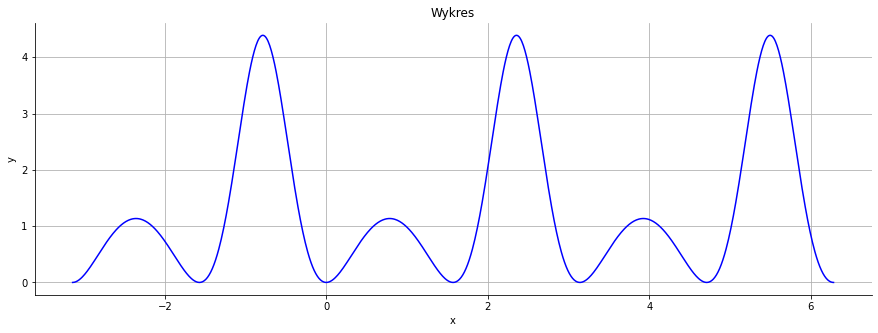

In [11]:
plt.figure(figsize=(15, 5))
plot_fn(g, a, b, step=.01)

## Interpolacja

### $1$. stopnia 
#### (interpolacja liniowa)

In [12]:
def Ψ(x, i, xs):
    if i < 0 or i > len(xs):
        raise ValueError("Wrong i value")
    if i > 0 and xs[i - 1] <= x <= xs[i]:
        return (x - xs[i - 1]) / (xs[i] - xs[i - 1])
    if i < len(xs) and xs[i] < x <= xs[i + 1]:
        return (xs[i + 1] - x) / (xs[i + 1] - xs[i])
    return 0

def binary_search(x, xs):
    l = 0
    r = len(xs) - 1
    
    while l <= r:
        m = (l + r) // 2
        if x > xs[m]:
            l = m + 1
        else:
            r = m - 1
        
    return l

def linear_spline(xs, ys):
    n = len(xs)
    
    def s(x):
        i = binary_search(x, xs)
        y = 0
        if i < n: 
            y += ys[i] * Ψ(x, i, xs)
            if i > 0: y += ys[i - 1] * Ψ(x, i - 1, xs)

        return y
    
    return s

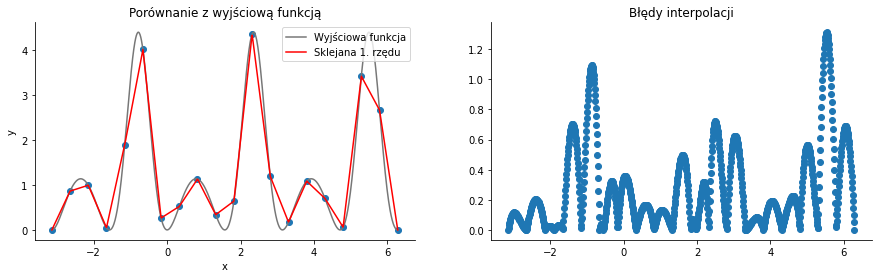

In [13]:
n = 20

rich_plot(
    PlotFn(g, "#777", "Wyjściowa funkcja"), 
    [PlotIntep(linear_spline, 'r', 'Sklejana 1. rzędu')], 
    a, b, n
)

### $2$. stopnia 
#### (interpolacja kwadratowa)

###### Pomocne: https://www2.icp.uni-stuttgart.de/~icp/mediawiki/images/1/10/SS_2017_PC_ws5_solution.pdf

In [14]:
from pprint import pprint as pp
import enum


# def gauss_jordan(A, B):
#     A = np.array(A, float)
#     B = np.array(B, float)
#     n = len(B)
    
#     for k in range(n):
#         # Partial pivoting
#         if np.fabs(A[k, k]) < 1e-12:
#             for i in range(k + 1, n):
#                 if np.fabs(A[i, k]) > np.fabs(A[k, k]):
#                     # Swap rows
#                     A[[k, i]] = A[[i, k]]  
#                     B[[k, i]] = B[[i, k]]
#                     break
#         # Division of the pivot row
#         pivot = A[k, k]
#         A[k] /= pivot
#         B[k] /= pivot
#         # Elimination loop
#         for i in range(n):
#             if i == k or A[i, k] == 0: continue
#             factor = A[i, k]
#             A[i] -= factor * A[k]
#             B[i] -= factor * B[k]
            
#     return B

class QuadBoundCond(enum.Enum): 
    NaturalBoundary = 0
    NotAKnot = 1
    
class QuadraticSpline:
    def __init__(self, xs, ys, *, boundary_condition=QuadBoundCond.NaturalBoundary):
        self.n = n = len(ys)  # The number of nodes
        self.xs = xs
        self.ys = ys
        self.bc = boundary_condition
        self.fns = []
        self.__solve()
        
    def __call__(self, x):
        i = min(self.search_range_idx(x), self.n - 1)
        return self.fns[i](x)
    
    def γ(self, i):
        return (self.ys[i] - self.ys[i - 1]) / (self.xs[i] - self.xs[i - 1])
    
    def search_range_idx(self, x):
        xs = self.xs
        l = 0
        r = self.n - 1

        while l <= r:
            m = (l + r) // 2
            if x >= xs[m]:
                l = m + 1
            else:
                r = m - 1

        return l - 1
    
    def __solve(self):
        match self.bc:
            case QuadBoundCond.NaturalBoundary:
                self.__solve_with_natural_boundary()
            case QuadBoundCond.NotAKnot:
                self.__solve_with_not_a_knot()
        
    def __solve_with_natural_boundary(self):
        n = self.n
        a_list = []
        b_list = [0]
        c_list = self.ys
        
        for i in range(1, n):
            b_list.append(2 * self.γ(i) - b_list[-1])

        for i in range(n - 1):
            a_list.append((b_list[i + 1] - b_list[i]) / (2 * (self.xs[i + 1] - self.xs[i])))
        a_list.append(0)
        
        self.__calc_functions(a_list, b_list, c_list)

    def __solve_with_not_a_knot(self):
        n = self.n
        a_list = []
        b_list = [self.γ(1) - self.γ(2) + self.γ(3)]
        c_list = [self.ys[-1], *self.ys[1:]]
        
        for i in range(1, n):
            b_list.append(2 * self.γ(i) - b_list[-1])

        for i in range(n - 1):
            a_list.append((b_list[i + 1] - b_list[i]) / (2 * (self.xs[i + 1] - self.xs[i])))
        a_list.append(0)
                
        self.__calc_functions(a_list, b_list, c_list)
        
    def __calc_functions(self, a_list, b_list, c_list):
        def s(i):
            a = a_list[i]
            b = b_list[i]
            c = c_list[i]
            return lambda x: a * (x - self.xs[i]) ** 2 + b * (x - self.xs[i]) + c
        
        for i in range(self.n):
            self.fns.append(s(i))
        
    @staticmethod
    def __differential_quotients(xs, ys):
        n = len(xs)
        Δs = list(ys)
        
        for j in range(1, n):
            for i in range(n - 1, j - 1, -1):
                Δs[i] = (Δs[i] - Δs[i - 1]) / (xs[i] - xs[i - j])
                
        return Δs

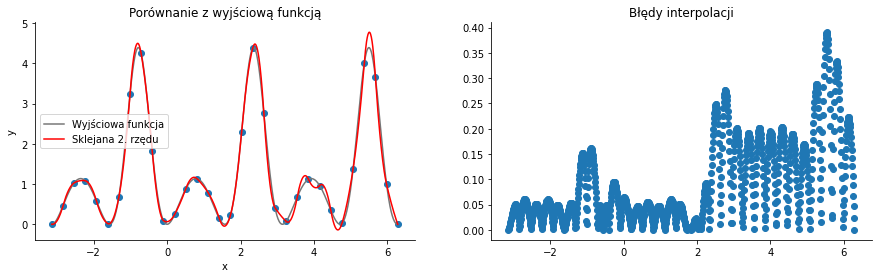

In [84]:
n = 32

rich_plot(
    PlotFn(g, "#777", "Wyjściowa funkcja"), 
    [PlotIntep(QuadraticSpline, 'r', 'Sklejana 2. rzędu', kwargs={'boundary_condition': QuadBoundCond.NotAKnot})], 
    a, b, n
)

### $3$. stopnia 
#### (interpolacja sześcienna)

In [63]:
from pprint import pprint as pp
import enum
    
# def det(A, B=None, substitute_idx=None):
#     n = len(A)
#     res = 0
#     for i in range(n):
#         diag1 = 1
#         diag2 = 1
#         for c1 in range(n):
#             r = (i + c1) % n
#             diag1 *= B[r] if c1 == substitute_idx else A[r][c1]
#             c2 = (n - c1) % n
#             diag2 *= B[r] if c2 == substitute_idx else A[r][c2]
#         res += diag1 - diag2
#     return res

def det_(A, B=None, substitute_idx=None):
    n = len(A)
    res = 0
    diags = np.ones(3)
    
    for i in range(n):
        if i > 0: diags[0] *= A[i, 0] if i - 1 != substitute_idx else B[i]
        diags[1] *= A[i, 1] if i != substitute_idx else B[i]
        if i < n - 1: diags[2] *= A[i, 2] if i + 1 != substitute_idx else B[i]

    return sum(diags)

def cramer(A, B):
    n = len(A)
    W = det_(A)
    W_ = [det_(A, B, i) for i in range(n)]  # A list of determinants
    return [W_[i] / W for i in range(n)]

class CubicBoundCond(enum.Enum):
    Derivative3rd = 0
    FreeBoundary = 1
    
class CubicSpline:
    def __init__(self, xs, ys, *, boundary_condition=CubicBoundCond.FreeBoundary):
        self.n = n = len(ys)
        self.xs = xs
        self.ys = ys
        self.bc = boundary_condition
        self.fns = []
        self.__solve()
        
    def __call__(self, x):
        i = min(self.search_range_idx(x), self.n - 2)
        return self.fns[i](x)
        
    def h(self, i):
        return self.xs[i + 1] - self.xs[i]
    
    def Δ(self, i):
        return (self.ys[i + 1] - self.ys[i]) / self.h(i)
    
    def search_range_idx(self, x):
        xs = self.xs
        l = 0
        r = self.n - 1

        while l <= r:
            m = (l + r) // 2
            if x >= xs[m]:
                l = m + 1
            else:
                r = m - 1

        return l - 1
        
    def __solve(self):
        match self.bc:
            case CubicBoundCond.Derivative3rd:
                return self.__solve_with_derivative_3rd()
            case CubicBoundCond.FreeBoundary:
                return self.__solve_with_free_boundary()
        
    def __solve_with_derivative_3rd(self):
        n = self.n
        h = self.h
        Δ = self.Δ
        A = np.zeros((n, 3))
        B = np.zeros(n)
        
        for i in range(1, self.n - 1):
            A[i, 0] = h(i - 1)
            A[i, 1] = 2 * (h(i - 1) + h(i))
            A[i, 2] = h(i)
            B[i] = Δ(i) - Δ(i - 1)
        
        # Apply boundary conditions
        start_xs = self.xs[:4]
        start_ys = self.ys[:4]
        end_xs = self.xs[-4:]
        end_ys = self.ys[-4:]
        Δs1 = self.__differential_quotients(start_xs, start_ys)
        Δs2 = self.__differential_quotients(end_xs, end_ys)
        
        # The first row
        A[0, 1] = -h(0)
        A[0, 2] = h(0)
        B[0] = h(0) ** 2 * Δs1[3]
        
        # The last row
        A[n - 1, 0] = h(n - 2)
        A[n - 1, 1] = -h(n - 2)
        B[n - 1] = -h(n - 2) ** 2 * Δs2[3]
            
        σs = cramer(A, B)  # Modified Cramer's algorithm to solve a system of equations
        
        self.__calc_functions(*self.__calc_coefficients(σs))
        
    def __solve_with_free_boundary(self):
        n = self.n
        h = self.h
        Δ = self.Δ
        A = np.zeros((n - 2, 3))
        B = np.zeros(n)
        
        for i in range(self.n - 2):
            A[i, 0] = h(i - 1)
            A[i, 1] = 2 * (h(i - 1) + h(i))
            A[i, 2] = h(i)
            B[i] = Δ(i) - Δ(i - 1)
            
        A[0, 0] = A[-1, -1] = 0
            
        σs = [0] + cramer(A, B) + [0]
        
        self.__calc_functions(*self.__calc_coefficients(σs))
        
    def __calc_coefficients(self, σs):
        a_list = []
        b_list = []
        c_list = []
        d_list = self.ys
        
        for i in range(self.n - 1):
            a_list.append((σs[i + 1] - σs[i]) / self.h(i))
            b_list.append(3 * σs[i])
            c_list.append((self.ys[i + 1] - self.ys[i]) / self.h(i) - self.h(i) * (σs[i + 1] + 2 * σs[i]))
        
        return a_list, b_list, c_list, d_list
        
    def __calc_functions(self, a_list, b_list, c_list, d_list):
        for i in range(self.n - 1):
            def s(i):
                a = a_list[i]
                b = b_list[i]
                c = c_list[i]
                d = d_list[i]
            
                def f(x):
                    diff = x - self.xs[i]
                    return a * diff**3 + b * diff**2 + c * diff + d
                return f
            
            self.fns.append(s(i))

    @staticmethod
    def __differential_quotients(xs, ys):
        n = len(xs)
        Δs = list(ys)
        
        for j in range(1, n):
            for i in range(n - 1, j - 1, -1):
                Δs[i] = (Δs[i] - Δs[i - 1]) / (xs[i] - xs[i - j])
                
        return Δs

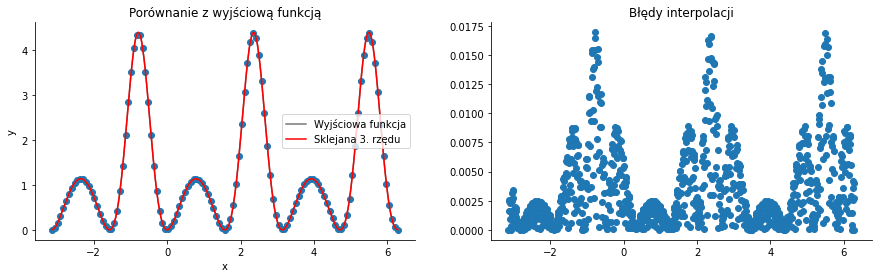

In [79]:
n = 123

rich_plot(
    PlotFn(g, "#777", "Wyjściowa funkcja"), 
    [PlotIntep(CubicSpline, 'r', 'Sklejana 3. rzędu', kwargs={'boundary_condition': CubicBoundCond.Derivative3rd})], 
    a, b, n
)

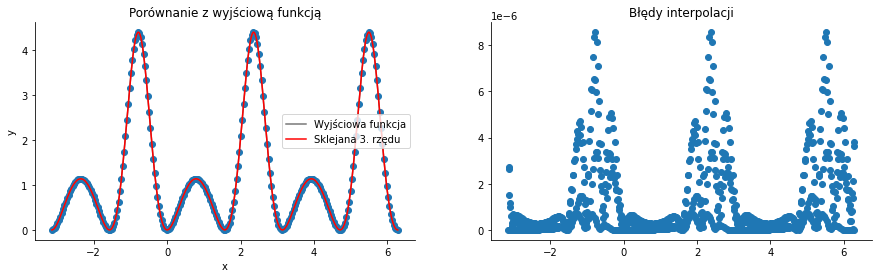

In [19]:
from scipy.interpolate import CubicSpline as CS

n = 250

rich_plot(
    PlotFn(g, "#777", "Wyjściowa funkcja"), 
    [PlotIntep(CS, 'r', 'Sklejana 3. rzędu')], 
    a, b, n
)